In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(psych,warn.conflicts=F)
library(lplyr,warn.conflicts=F)

In [2]:
# load the stats
data.tourney <- readRDS('datafiles_rds/NCAATourneyDetailedResults.rds')
# keep 2014+
data.tourney %>% filter(Season>2013) -> data.tourney

In [3]:
# store 68 tourney teams 
data.tourney %>% 
    select(Season,TeamID=WTeamID) %>% 
    bind_rows(data.tourney %>% 
              select(Season,TeamID=LTeamID)) %>% 
    distinct(Season,TeamID) -> df.tourneyteams

In [4]:
# Massey Rating 2014+
# https://www.masseyratings.com/team.php?s=nfl&t=nfl2014&all=6
data.massey <- read.csv('datafiles_csv/MasseyRatings.csv',stringsAsFactors=F)
data.massey %>% head

Season,Team,Conference,Record,WinPct,Rank,Rating,PowerRank,Power,OffRank,Offence,DefRank,Defense,HFA,SOSRank,SOS
2014,Florida,Southeastern,36-3,0.92,1,2.97,1,51.26,76,91.14,2,34.74,3.72,6,38.56
2014,Connecticut,American Athletic,32-8,0.80,2,2.78,6,48.64,43,92.93,7,30.32,2.28,3,38.76
2014,Louisville,American Athletic,31-6,0.84,3,2.68,2,51.24,10,97.99,15,27.86,3.41,24,36.20
2014,Arizona,Pac 12,33-5,0.87,4,2.67,3,49.78,42,92.99,3,31.41,4.53,8,37.80
2014,Wichita St,Missouri Val,35-1,0.97,5,2.67,5,48.76,27,94.70,11,28.67,4.74,97,31.38
2014,Virginia,Atlantic Coast,30-7,0.81,6,2.66,4,49.16,119,88.65,1,35.12,3.16,9,37.31


In [5]:
# We need Name, Rank and Rating as column name
data.massey %>% rename(Name=Team) -> data.massey

In [6]:
# load team spellings variations
data.teamspellings <- readRDS('datafiles_rds/TeamSpellings.rds')
data.teams <- readRDS('datafiles_rds/Teams.rds')

In [7]:
# add TeamID based on team name
data.massey %>% 
    mutate(LowName=str_to_lower(Name)) %>% 
    left_join(data.teamspellings,by=c('LowName'='TeamNameSpelling')) -> df.ratingsystem

In [8]:
df.ratingsystem %>% filter(str_detect(Name,'Albany'))

Season,Name,Conference,Record,WinPct,Rank,Rating,PowerRank,Power,OffRank,Offence,DefRank,Defense,HFA,SOSRank,SOS,LowName,TeamID
2014,Albany NY,America East,19-15,0.56,161,1.49,161,27.70,260,81.98,87,20.34,2.90,226,24.53,albany ny,1107
2015,Albany NY,America East,24-9,0.73,99,1.70,129,28.53,228,80.58,79,20.66,1.79,233,23.36,albany ny,1107
2016,Albany NY,America East,24-9,0.73,154,1.50,143,28.14,186,86.85,124,17.45,1.47,274,21.95,albany ny,1107
2017,Albany NY,America East,21-14,0.60,152,1.52,128,31.23,230,86.84,76,21.11,1.78,225,26.24,albany ny,1107
2018,Albany NY,America East,22-10,0.69,168,1.44,171,29.16,209,88.14,138,17.91,1.69,274,25.04,albany ny,1107


In [9]:
# missing tourney team in stats (because name misspelling)
df.ratingsystem %>% 
    right_join(df.tourneyteams,by='TeamID') %>%
    filter(is.na(Rank)) %>%
    select(TeamID) %>%
    inner_join(data.teams,by='TeamID') %>%
    distinct() %>%
    arrange(TeamID)

TeamID,TeamName,FirstD1Season,LastD1Season


In [10]:
# check if ssomething is still wrong
df.ratingsystem %>% 
    right_join(df.tourneyteams,by='TeamID') %>%
    filter(is.na(Rank)) %>%
    select(TeamID) %>%
    inner_join(data.teams,by='TeamID') %>%
    distinct() %>%
    arrange(TeamID)

TeamID,TeamName,FirstD1Season,LastD1Season


In [11]:
# restrict stats to tourney teams
df.ratingsystem %>% 
    inner_join(df.tourneyteams,by=c('TeamID','Season')) %>%
    select(Season,TeamID,Rating) -> df.ratingsystem

In [12]:
# Check if we have 68 teams per Season
df.ratingsystem %>% 
    group_by(Season) %>% 
    count

Season,n
2014,68
2015,68
2016,68
2017,68
2018,68


In [13]:
# check missing TeamID per Season 
df.tourneyteams %>% 
    anti_join(df.ratingsystem,by=c('Season','TeamID')) %>%
    inner_join(data.teams,by='TeamID') %>%
    select(TeamID,TeamName) %>%
    distinct()

TeamID,TeamName


In [14]:
# load true results
data.truth <- readRDS('datafiles_rds/TourneyTrueResults.rds')

In [15]:
# slope hyper parameter grid : we will compute 99 models and chose the best one (min logloss)
df.ratingsystem %>% 
    mutate(dummy=1) %>% 
    inner_join(data.frame(qtl=seq(0.01,0.99,0.01),dummy=1),by='dummy') %>% 
    select(-dummy) %>% 
    group_by(qtl,Season) %>% 
    mutate(thres=max(Rating)-quantile(Rating,max(qtl)),Slope=3/thres) %>%
    ungroup %>% 
    select(Season,qtl,Slope) %>% 
    distinct() -> df.slopes
df.slopes %>% sample_n(5)

Season,qtl,Slope
2016,0.57,3.658537
2015,0.88,5.165289
2016,0.96,12.195122
2016,0.05,1.746217
2017,0.18,2.637131


In [16]:
# matchups dataframe : all the possible matches between the 68 teams per Season 
df.ratingsystem %>% 
    inner_join(df.ratingsystem,by='Season') %>% 
    filter(TeamID.x < TeamID.y) -> df.matchup
df.matchup %>% sample_n(5)

Season,TeamID.x,Rating.x,TeamID.y,Rating.y
2014,1328,2.13,1438,2.66
2016,1195,1.51,1437,3.10
2016,1211,2.47,1403,2.04
2015,1329,1.87,1385,1.99
2016,1195,1.51,1338,2.27


In [17]:
# all matchs with all 51 hyper parameter setting (qtl=[0.25,0.75]) 
df.matchup %>% inner_join(df.slopes,by=c('Season')) -> df.matchup
df.matchup %>% sample_n(5)

Season,TeamID.x,Rating.x,TeamID.y,Rating.y,qtl,Slope
2015,1125,1.71,1279,1.99,0.43,2.772900
2018,1113,1.80,1305,2.20,0.85,5.550416
2016,1201,2.05,1332,2.66,0.36,2.880184
2018,1211,2.41,1344,2.12,0.42,3.296703
2018,1166,2.01,1455,2.12,0.13,2.479339


In [18]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
df.matchup %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(qtl,ID,Pred,Prob) -> df.submit
df.submit %>% sample_n(5)

qtl,ID,Pred,Prob
0.20,2014_1153_1160,1,0.663
0.71,2018_1301_1420,1,0.677
0.95,2017_1112_1411,1,0.950
0.23,2018_1166_1276,0,0.124
0.50,2016_1246_1393,1,0.526


In [19]:
# merge prediction and truth
data.truth %>% inner_join(df.submit,by='ID') -> df.results

In [33]:
# compute accuracy & Logloss per qtl to find the best one
df.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(qtl,TC,FC,N,Acc,LogLoss) -> df.results.perf
df.results.perf %>% arrange(LogLoss) %>% head()

qtl,TC,FC,N,Acc,LogLoss
0.88,279,56,335,0.8328358,0.3706242
0.89,279,56,335,0.8328358,0.3706546
0.87,279,56,335,0.8328358,0.3711077
0.90,279,56,335,0.8328358,0.3716894
0.91,279,56,335,0.8328358,0.3719627
0.86,279,56,335,0.8328358,0.3720656


In [31]:
library(ggplot2,warn.conflicts=F)

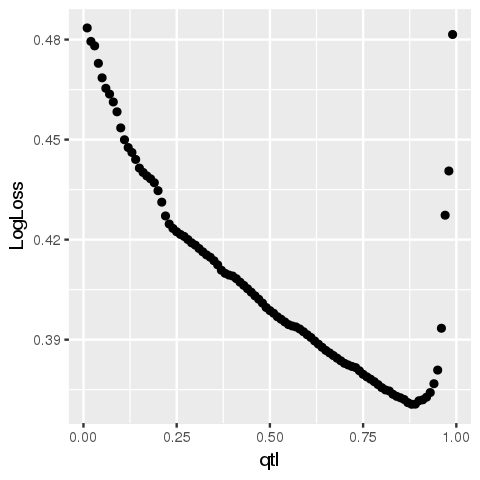

In [32]:
options(repr.plot.width=4, repr.plot.height=4)
qplot(data=df.results.perf,x=qtl,y=LogLoss)

In [24]:
# store the best qtl
df.results.perf %>% 
    arrange(LogLoss) %>% 
    head(1) %>% pull(qtl) -> bestqtl

In [25]:
# save the best results for kaggle submission
df.submit %>% 
    filter(qtl==bestqtl) %>% 
    select(ID,Pred=Prob) %>% 
    write.csv('predictions/Pred_Massey_bestqtl.csv',quote=F,row.names=F)

In [26]:
# save best model for mix
df.submit %>%
    filter(qtl==bestqtl) %>% 
    saveRDS('predictions/Massey_bestqtl.rds')    